In [1]:
import os
import deepchem as dc
import numpy as np
import pandas as pd
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES']='1'

/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## model setup

In [2]:
from model_training_utils_v2 import prepare_dataset
import os
import pandas as pd

RUN_KEY = 'Serotonin_Aug14'

log_path = './logs/' + RUN_KEY
os.system('mkdir %s' % log_path)
dataset_file = '%s/raw_data.csv' % (log_path)
MT_dat_name = './data/MT_data_clean_June28.csv'
FP_type = 'Circular_2048'
task_list = ['T51', 'T106','T107','T227', 'T108'] # 5HT-1a/1b/2a/2b/2c
#add_features = ['MW', 'logP', 'BertzCT', 'TPSA']

n_features = 2048
layer_sizes = [512, 64]
bypass_layer_sizes=[128]
bypass_dropouts = [.5]
dropout = 0.5
lr = 0.0005

## model training

In [3]:
from keras.layers import Dense, Input
from keras.layers.core import Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from model_training_utils_v2 import prepare_dataset

def RobustMT_model_training(MT_dat_name, FP_type, task_list, log_path, epoch_num = 10,
                            n_features, layer_sizes, bypass_layer_sizes, bypass_dropouts, dropout, lr,
                            N_test = 500.0, add_features = None, n_epoch = 40):
    
    dataset_file = '%s/raw_data.csv' % (log_path)
    if len(task_list) > 1:
        model_flag = 'MT'
    else:
        model_flag = 'ST'
    dataset, df = prepare_dataset(MT_dat_name, task_list, dataset_file, FP_type, 
                              smiles_field = 'canonical_smiles', 
                              add_features = add_features,
                              id_field = 'chembl_id', model_flag = model_flag)

    # calculate the ratio of missing values in the multitask setting
    weights = dataset.w
    true_cnt = sum(sum(weights))
    missing_ratio = 1 - (true_cnt / (weights.shape[0] * weights.shape[1]))
    print('Missing ratio of the dataset is %.2f' % missing_ratio)
    print('Number of valid samples is %d' % int(true_cnt))

    # split dataset
    frac_train = 1 - N_test / dataset.X.shape[0]
    splitter = dc.splits.RandomSplitter(dataset_file)
    train_dataset, test_dataset = splitter.train_test_split(dataset, frac_train = frac_train)

    metric = dc.metrics.Metric(
        dc.metrics.r2_score, np.mean, mode = 'regression')

    # model training 
    n_tasks = len(task_list)
    model = dc.models.RobustMultitaskRegressor(n_tasks = n_tasks, n_features = n_features, layer_sizes = layers_sizes,
                                               bypass_layer_sizes=bypass_layer_sizes, bypass_dropouts = bypass_dropouts,
                                               dropout = dropout, learning_rate = lr)
    model.save_file = log_path + '/model'

    train_evaluation = []
    test_evaluation = []
    for iteration in range(epoch_num):
        model.fit(train_dataset, n_epoch = n_epoch, max_checkpoints_to_keep = 1, checkpoint_interval=20)
        print('======== Iteration %d ======' % iteration)
        print("Evaluating model")
        train_scores = model.evaluate(train_dataset, [metric], [], per_task_metrics=metric)
        train_evaluation.append(train_scores[1]["mean-r2_score"])
        print("Training R2 score: %f" % train_scores[0]["mean-r2_score"])
        test_scores = model.evaluate(test_dataset, [metric], [], per_task_metrics=metric)
        test_evaluation.append(test_scores[1]["mean-r2_score"])
        print("Test R2 score: %f" % test_scores[0]["mean-r2_score"])
        
        # save evaluation scores (need test!)
        train_df = pd.DataFrame(np.array(train_evaluation))
        test_df = pd.DataFrame(np.array(test_evaluation))
        train_df.to_csv(model.save_file + '_train_log.csv')
        test_df.to_csv(model.save_file + '_test_log.csv')
    return 

In [4]:
RobustMT_model_training(MT_dat_name, FP_type, task_list, log_path, epoch_num = 10, N_test = 500.0, add_features = None, n_epoch = 40)

/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (767) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Extracted dataset shape: (6451, 7)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./logs/Serotonin_Aug14/raw_data.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
TIMING: featurizing shard 0 took 25.922 s
TIMING: dataset construction took 26.403 s
Loading dataset from disk.
Missing ratio of the dataset is 0.69
Number of valid samples is 10088
Computing train/valid/test indices
TIMING: dataset construction took 0.634 s
Loading dataset from disk.
TIMING: dataset construction took 0.258 s
Loading dataset from disk.
======== Iteration 0 ======
Evaluating model
computed_metrics: [0.759661163147638, 0.8487385832755133, 0.7927909892421446, 0.7862606713724265, 0.7956715188464687]
Training R2 score: 0.796625
computed_metrics: [0.5752939701171875, 0.6945875534170977, 0.6066652533645858, 0.37844448486926474, 0.662592404409

In [3]:
# visualize the evaluation scores along the training process
import seaborn as sns
import pandas as pd
from VISAR_model_utils_v2 import generate_performance_plot_RobustMT

plot_df = generate_performance_plot_RobustMT(train_file = './logs/Serotonin_Aug14/model_train_log.csv',
                                             test_file = './logs/Serotonin_Aug14/model_test_log.csv',
                                             task_list = ['T51', 'T106','T107','T227', 'T108'])

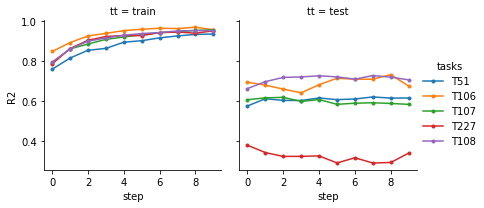

In [9]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(plot_df, col = 'tt', hue = 'tasks')
g = (g.map(plt.plot, 'step', 'R2', marker = '.')).add_legend()

## process trained results for VISAR analysis

In [4]:
from VISAR_model_utils_v2 import generate_RUNKEY_dataframe_RobustMT
prev_model = './logs/Serotonin_Aug14/model-1200'
RUNKEY = './logs/Serotonin_Aug14/'

task_list = ['T51', 'T106','T107','T227', 'T108'] # 5HT-1a/1b/2a/2b/2c
#add_features = ['MW','logP','BertzCT','TPSA']
dataset_file = '%s/raw_data.csv' % (RUNKEY)
MT_dat_name = './data/MT_data_clean_June28.csv'
FP_type = 'Circular_2048'
model_flag = 'MT'

n_features = 2048
layer_sizes = [512, 64]
bypass_layer_sizes=[128]
bypass_dropouts = [.5]
dropout = 0.5
learning_rate = 0.001
n_layer = 2
n_bypass = 2
add_features = None

output_prefix = RUNKEY + '/RobustMT_serotonin_output_'

In [5]:
generate_RUNKEY_dataframe_RobustMT(prev_model, output_prefix, task_list, dataset_file, FP_type, add_features, 
                                   n_features, layer_sizes, bypass_layer_sizes, model_flag, n_bypass, n_layer = n_layer)

------------- Loading dataset --------------------


/root/anaconda3/envs/deepchem/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (767) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Extracted dataset shape: (6451, 7)
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ./logs/Serotonin_Aug14//raw_data.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
TIMING: featurizing shard 0 took 24.339 s
TIMING: dataset construction took 24.805 s
Loading dataset from disk.
------------- Loading previous trained models ------------------
INFO:tensorflow:Restoring parameters from ./logs/Serotonin_Aug14/model-1200
------------- Prepare information for chemicals ------------------
INFO:tensorflow:Restoring parameters from ./logs/Serotonin_Aug14/model-1200
Instructions for updating:
keep_dims is deprecated, use keepdims instead
------------- Prepare information for minibatches ------------------
------------- Prepare information for tasks ------------------
INFO:tensorflow:Restoring parameters from ./logs/Serotonin

Next:
- copy output files (including output_compound_df, output_batch_df, output_task_df) to VISAR_webapp data directory, and clear the static directory if neccessary;
- start the app in prompt window by 'bokeh serve --show VISAR_webapp'